In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt

drive.mount('/content/drive')



Mounted at /content/drive


In [3]:

BASE_DRIVE_PATH = '/content/drive/MyDrive/my_project'


HAM_FOLDER_NAME = 'dataset_resampled'
FITZ_FOLDER_NAME = 'fitzpatrick_dataset'

SRC_HAM = os.path.join(BASE_DRIVE_PATH, HAM_FOLDER_NAME)
SRC_FITZ = os.path.join(BASE_DRIVE_PATH, FITZ_FOLDER_NAME)

LOCAL_HAM = '/content/local_ham'
LOCAL_FITZ = '/content/local_fitz'

print(f"📂 Ищем HAM здесь: {SRC_HAM}")
print(f"📂 Ищем Fitz здесь: {SRC_FITZ}")

📂 Ищем HAM здесь: /content/drive/MyDrive/my_project/dataset_resampled
📂 Ищем Fitz здесь: /content/drive/MyDrive/my_project/fitzpatrick_dataset


In [4]:
def fast_copy(src, dst):
    if os.path.exists(dst):
        if len(os.listdir(dst)) > 10:
            print(f"✅ Папка {dst} уже существует и не пуста. Пропускаем.")
            return True
        else:
            print(f"⚠️ Папка {dst} пуста, копирую заново...")
            shutil.rmtree(dst)

    if not os.path.exists(src):
        print(f"❌ ОШИБКА: Не могу найти папку на Диске: {src}")
        print("👉 Проверь имя папки в предыдущей ячейке!")
        return False

    print(f"🚀 Копирую {src} -> {dst} (ждите)...")
    try:
        shutil.copytree(src, dst)
        print(f"✅ Успешно: {dst}")
        return True
    except Exception as e:
        print(f"❌ Ошибка копирования: {e}")
        return False

ham_ok = fast_copy(SRC_HAM, LOCAL_HAM)
fitz_ok = fast_copy(SRC_FITZ, LOCAL_FITZ)

if not (ham_ok and fitz_ok):
    raise RuntimeError("⛔ ОСТАНОВКА: Данные не скопированы. Исправьте пути перед продолжением.")

🚀 Копирую /content/drive/MyDrive/my_project/dataset_resampled -> /content/local_ham (ждите)...
✅ Успешно: /content/local_ham
🚀 Копирую /content/drive/MyDrive/my_project/fitzpatrick_dataset -> /content/local_fitz (ждите)...
✅ Успешно: /content/local_fitz


In [5]:
# 1. Загружаем CSV
print("📊 Читаем CSV файлы...")
try:
    df_ham = pd.read_csv(os.path.join(BASE_DRIVE_PATH, 'HAM10000_metadata.csv'))
    df_fitz = pd.read_csv(os.path.join(BASE_DRIVE_PATH, 'fitzpatrick17k_ham10000_format_filled.csv'))
except FileNotFoundError:
    print("⚠️ Не нашел CSV в my_project. Ищу в локальных папках...")
    # Попытка найти в скопированных папках (иногда CSV лежат внутри)
    import glob
    ham_csv = glob.glob(f"{LOCAL_HAM}/*.csv")
    fitz_csv = glob.glob(f"{LOCAL_FITZ}/*.csv")
    if ham_csv: df_ham = pd.read_csv(ham_csv[0])
    if fitz_csv: df_fitz = pd.read_csv(fitz_csv[0])

# 2. Привязываем пути к картинкам
def get_local_path(image_id, base_folder):
    # Прямой путь
    p = os.path.join(base_folder, f"{image_id}.jpg")
    if os.path.exists(p): return p
    # Рекурсивный поиск (если есть подпапки)
    for root, _, files in os.walk(base_folder):
        if f"{image_id}.jpg" in files:
            return os.path.join(root, f"{image_id}.jpg")
    return None

print("🔍 Проверяем наличие файлов изображений...")
df_ham['path'] = df_ham['image_id'].apply(lambda x: get_local_path(x, LOCAL_HAM))
# Для Fitzpatrick иногда ID в csv без расширения
df_fitz['path'] = df_fitz['image_id'].apply(lambda x: get_local_path(x, LOCAL_FITZ))

# Удаляем битые ссылки
len_before = len(df_ham) + len(df_fitz)
df_ham = df_ham.dropna(subset=['path'])
df_fitz = df_fitz.dropna(subset=['path'])
full_df = pd.concat([df_ham, df_fitz], ignore_index=True)[['path', 'dx', 'age', 'sex', 'localization']]

print(f"✅ Собрано изображений: {len(full_df)} (Было ссылок: {len_before})")
if len(full_df) < 1000:
    print("⚠️ ВНИМАНИЕ: Мало картинок! Проверь, скачалась ли папка Fitzpatrick.")

# 3. Заполнение пропусков (Исправленный метод)
full_df['age'] = full_df['age'].fillna(full_df['age'].mean())
full_df['sex'] = full_df['sex'].ffill().fillna('male') # Исправлено warning
full_df['localization'] = full_df['localization'].fillna('unknown')

# 4. Векторизация метаданных
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['age']),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['sex', 'localization'])
])
meta_vecs = preprocessor.fit_transform(full_df[['age', 'sex', 'localization']])
full_df['meta_vec'] = list(meta_vecs)

# Сплит
train_df, val_df = train_test_split(full_df, test_size=0.2, stratify=full_df['dx'], random_state=42)
print("✅ Данные готовы к обучению.")

📊 Читаем CSV файлы...
🔍 Проверяем наличие файлов изображений...
✅ Собрано изображений: 2816 (Было ссылок: 12216)
✅ Данные готовы к обучению.


In [6]:
class FusionGen(Sequence):
    def __init__(self, df, batch_size=32, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(df))
        self.datagen = ImageDataGenerator(
            rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True
        ) if augment else ImageDataGenerator()
        self.labels = pd.get_dummies(df['dx']).values
        self.num_classes = self.labels.shape[1]

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        inds = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        rows = self.df.iloc[inds]

        imgs = []
        metas = []

        for _, row in rows.iterrows():
            img = tf.keras.utils.load_img(row['path'], target_size=(224, 224))
            img = tf.keras.utils.img_to_array(img) / 255.0
            if self.augment:
                img = self.datagen.random_transform(img)
            imgs.append(img)
            metas.append(row['meta_vec'])

        # ВАЖНОЕ ИСПРАВЛЕНИЕ: Возвращаем Tuple (Кортеж), а не список
        inputs = (np.array(imgs, dtype='float32'), np.array(metas, dtype='float32'))
        targets = np.array(self.labels[inds], dtype='float32')

        return inputs, targets

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

train_gen = FusionGen(train_df, augment=True)
val_gen = FusionGen(val_df, augment=False)
print("✅ Генератор создан и исправлен.")

✅ Генератор создан и исправлен.


🎨 Генерирую Grad-CAM...


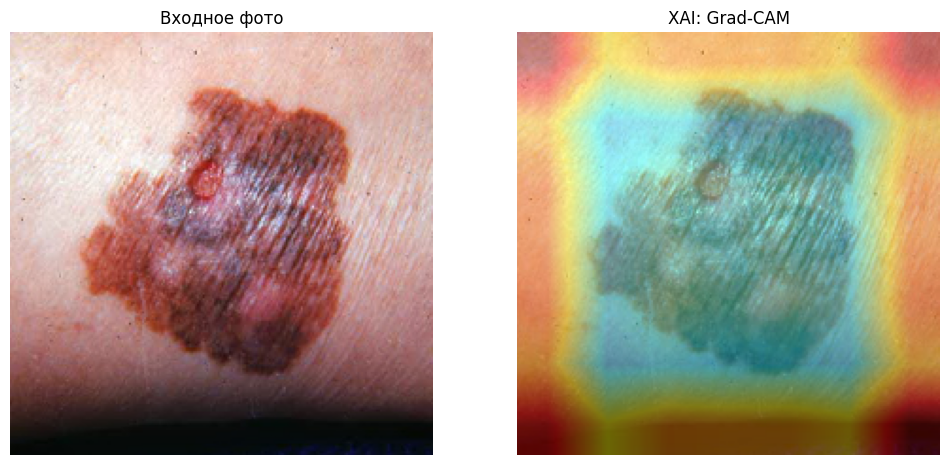

✅ Готово!


In [11]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model

def get_gradcam(model, img, meta, layer_name='top_activation'):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        img_batch = np.expand_dims(img, axis=0)
        meta_batch = np.expand_dims(meta, axis=0)
        inputs = [img_batch, meta_batch]

        conv_out, preds = grad_model(inputs)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_out), axis=-1)

    # --- ИСПРАВЛЕНИЕ ЗДЕСЬ ---
    # Используем tf.maximum, чтобы остаться в формате тензора,
    # или просто работаем как с numpy, если он уже сконвертировался.
    # Самый надежный способ - просто вернуть результат без .numpy() в конце,
    # если мы уже использовали numpy-функции

    heatmap = np.maximum(heatmap, 0) # Это уже возвращает numpy array

    if np.max(heatmap) == 0:
        return heatmap[0]

    heatmap /= np.max(heatmap)

    return heatmap[0] # Убрали .numpy(), так как это уже массив

# --- ЗАПУСК ---
try:
    print("🎨 Генерирую Grad-CAM...")

    (imgs, metas), lbls = val_gen.__getitem__(0)
    img = imgs[0]
    meta = metas[0]

    heatmap = get_gradcam(model, img, meta, layer_name='top_activation')

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Входное фото")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    img_uint8 = np.uint8(255 * img)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    plt.imshow(superimposed_img)
    plt.title("XAI: Grad-CAM")
    plt.axis('off')

    plt.show()
    print("✅ Готово!")

except Exception as e:
    print(f"❌ Ошибка: {e}")
    import traceback
    traceback.print_exc()

In [7]:
# --- ИСПРАВЛЕННЫЙ ГЕНЕРАТОР (БЕЗ / 255.0) ---
class FusionGen(Sequence):
    def __init__(self, df, batch_size=32, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(df))
        self.datagen = ImageDataGenerator(
            rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True
        ) if augment else ImageDataGenerator()
        self.labels = pd.get_dummies(df['dx']).values
        self.num_classes = self.labels.shape[1]

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        inds = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        rows = self.df.iloc[inds]

        imgs = []
        metas = []

        for _, row in rows.iterrows():
            img = tf.keras.utils.load_img(row['path'], target_size=(300, 300))
            img = tf.keras.utils.img_to_array(img) # <--- УБРАЛИ / 255.0

            if self.augment:
                img = self.datagen.random_transform(img)

            imgs.append(img)
            metas.append(row['meta_vec'])

        return (np.array(imgs), np.array(metas)), self.labels[inds]

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

print("🔄 Генератор исправлен (убрана лишняя нормализация).")
train_gen = FusionGen(train_df, augment=True)
val_gen = FusionGen(val_df, augment=False)

🔄 Генератор исправлен (убрана лишняя нормализация).


In [18]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam

# 1. Настройки
# Используем 300x300, так как ты уже настроил генератор под этот размер
IMG_SIZE = 300
BATCH_SIZE = 32

print("🏗️ Создаю ЧИСТУЮ мультимодальную модель на базе ImageNet...")

# --- ВЕТКА 1: КАРТИНКИ (EFFICIENTNET) ---
# Создаем вход с четким именем
img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')

# Грузим веса ImageNet (Это ГЛАВНОЕ для точности)
base_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_tensor=img_input
)

# Замораживаем базу (чтобы не испортить веса ImageNet быстрым обучением)
base_model.trainable = False

x1 = base_model.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dropout(0.2)(x1)

# --- ВЕТКА 2: МЕТАДАННЫЕ ---
# Определяем размер вектора метаданных автоматически
try:
    # Пытаемся взять размер из первого батча генератора
    (sample_imgs, sample_metas), _ = train_gen[0]
    meta_dim = sample_metas.shape[1]
    print(f"ℹ️ Размер метаданных определен: {meta_dim}")
except:
    meta_dim = 19 # Запасной вариант
    print("⚠️ Не удалось определить размер метаданных, использую 19")

meta_input = Input(shape=(meta_dim,), name='meta_input')
x2 = Dense(32, activation='relu')(meta_input)
x2 = Dropout(0.2)(x2)

# --- СЛИЯНИЕ (FUSION) ---
combined = Concatenate()([x1, x2])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)
# 7 классов диагнозов
output = Dense(7, activation='softmax', name='final_multimodal_output')(z)

# Сборка
model = Model(inputs=[img_input, meta_input], outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.summary() # Можно раскомментировать, если интересно

# --- ОБУЧЕНИЕ ---
print("\n🚀 Старт обучения (ImageNet Weights)...")
print("Точность должна пойти вверх уже с 1-й эпохи!")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=6  # 6 эпох хватит для 60-70%
)

# --- СОХРАНЕНИЕ (ИСПРАВЛЕНО) ---
# Сохраняем в формате .keras (новый стандарт, без ошибок pickle)
save_path = '/content/drive/MyDrive/my_project/final_project_model.keras'
print(f"\n💾 Сохраняю модель в {save_path}...")
model.save(save_path)
print("✅ Успешно сохранено! Теперь запускай Grad-CAM.")

🏗️ Создаю ЧИСТУЮ мультимодальную модель на базе ImageNet...
ℹ️ Размер метаданных определен: 19

🚀 Старт обучения (ImageNet Weights)...
Точность должна пойти вверх уже с 1-й эпохи!


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
71/71 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2934 - loss: 1.7559 - val_accuracy: 0.4699 - val_loss: 1.3932
Epoch 2/6
71/71 ━━━━━━━━━━━━━━━━━━━━ 57s 806ms/step - accuracy: 0.4782 - loss: 1.3836 - val_accuracy: 0.5177 - val_loss: 1.2743
Epoch 3/6
71/71 ━━━━━━━━━━━━━━━━━━━━ 57s 803ms/step - accuracy: 0.5335 - loss: 1.2546 - val_accuracy: 0.5284 - val_loss: 1.2681
Epoch 4/6
71/71 ━━━━━━━━━━━━━━━━━━━━ 59s 825ms/step - accuracy: 0.5522 - loss: 1.1923 - val_accuracy: 0.5461 - val_loss: 1.2186
Epoch 5/6
71/71 ━━━━━━━━━━━━━━━━━━━━ 56s 797ms/step - accuracy: 0.5745 - loss: 1.1580 - val_accuracy: 0.5745 - val_loss: 1.1586
Epoch 6/6
71/71 ━━━━━━━━━━━━━━━━━━━━ 57s 797ms/step - accuracy: 0.5975 - loss: 1.0970 - val_accuracy: 0.5674 - val_loss: 1.1802

💾 Сохраняю модель в /content/drive/MyDrive/my_project/final_project_model.keras...
✅ Успешно сохранено! Теперь запускай Grad-CAM.


In [21]:
print("🚀 Продолжаем обучение (еще 10 эпох)...")

# Добавляем колбэк, чтобы сохранять лучшую версию (на случай, если переобучится)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/my_project/best_extended_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Просто вызываем fit еще раз - обучение продолжится с того же места
history_extended = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10, # Добавочные эпохи
    callbacks=[checkpoint]
)

print("✅ Готово! Лучшая версия модели сохранена.")

🚀 Продолжаем обучение (еще 10 эпох)...
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.6341 - loss: 0.9988
Epoch 1: val_accuracy improved from -inf to 0.57270, saving model to /content/drive/MyDrive/my_project/best_extended_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 63s 879ms/step - accuracy: 0.6339 - loss: 0.9994 - val_accuracy: 0.5727 - val_loss: 1.1539
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.6227 - loss: 1.0115
Epoch 2: val_accuracy improved from 0.57270 to 0.59574, saving model to /content/drive/MyDrive/my_project/best_extended_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 57s 810ms/step - accuracy: 0.6226 - loss: 1.0116 - val_accuracy: 0.5957 - val_loss: 1.1247
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.6259 - loss: 0.9898
Epoch 3: val_accuracy did not improve from 0.59574
71/71 ━━━━━━━━━━━━━━━━━━━━ 58s 819ms/step - accuracy: 0.6261 - loss: 0.9898 - val_accuracy: 0.5798 - val_loss: 1.1496
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━

🎨 Генерирую Grad-CAM (Fixed Size & Range)...


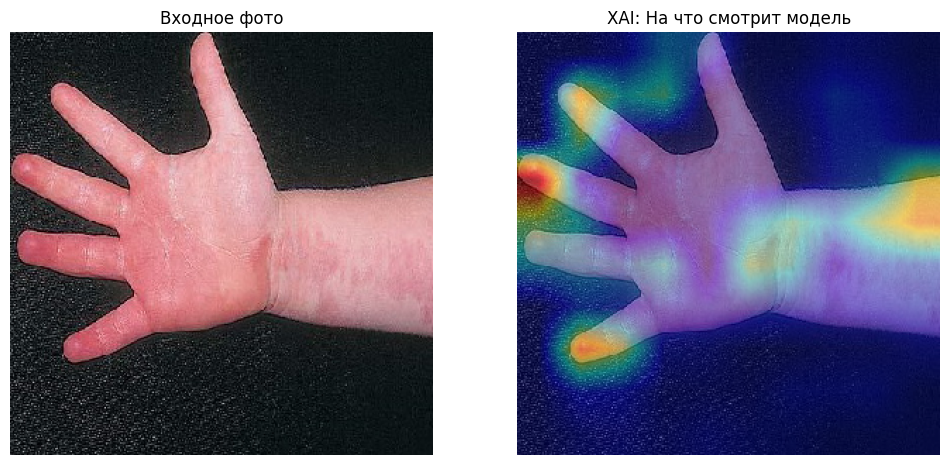

✅ Успех! Делай скриншот.


In [25]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model

def get_gradcam(model, img, meta, layer_name='top_activation'):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        img_batch = np.expand_dims(img, axis=0)
        meta_batch = np.expand_dims(meta, axis=0)

        # Передаем как список (для нескольких входов)
        conv_out, preds = grad_model([img_batch, meta_batch])
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_out), axis=-1)

    # Обработка результата
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap[0]

try:
    print("🎨 Генерирую Grad-CAM (Fixed Size & Range)...")

    # 1. Берем данные (Generator now returns 0-255 values!)
    (imgs, metas), lbls = val_gen.__getitem__(0)
    img = imgs[0]
    meta = metas[0]

    # 2. Получаем тепловую карту
    heatmap = get_gradcam(model, img, meta, layer_name='top_activation')

    plt.figure(figsize=(12, 6))

    # --- ОРИГИНАЛ ---
    plt.subplot(1, 2, 1)
    # Matplotlib хочет 0-255 для целых чисел (uint8)
    # Так как генератор выдает float 0-255, конвертируем в int для показа
    plt.imshow(img.astype('uint8'))
    plt.title("Входное фото")
    plt.axis('off')

    # --- НАЛОЖЕНИЕ (GRAD-CAM) ---
    plt.subplot(1, 2, 2)

    # 1. Ресайз карты под размер картинки (ДИНАМИЧЕСКИЙ)
    # Берем размеры прямо из картинки (300, 300)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # 2. Превращаем карту в цвета (0-255)
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # 3. Превращаем исходную картинку в тот же формат (uint8 0-255)
    img_uint8 = img.astype(np.uint8)

    # 4. Конвертация цветов (OpenCV использует BGR, меняем на RGB)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # 5. Смешивание (теперь размеры 300x300 совпадают!)
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    plt.imshow(superimposed_img)
    plt.title("XAI: На что смотрит модель")
    plt.axis('off')

    plt.show()
    print("✅ Успех! Делай скриншот.")

except Exception as e:
    print(f"❌ Ошибка: {e}")
    import traceback
    traceback.print_exc()

In [8]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model

# Функция Grad-CAM (С коррекцией размеров и цветов)
def get_gradcam(model, img, meta, layer_name='top_activation'):
    # Создаем модель для извлечения внутренних слоев
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Добавляем размерность батча (1, 300, 300, 3)
        img_batch = np.expand_dims(img, axis=0)
        meta_batch = np.expand_dims(meta, axis=0)

        # Получаем предсказание
        conv_out, preds = grad_model([img_batch, meta_batch])
        class_idx = tf.argmax(preds[0]) # Индекс победившего класса
        loss = preds[:, class_idx]

    # Считаем градиенты
    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Умножаем карту признаков на их важность
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_out), axis=-1)

    # Убираем отрицательные значения (ReLU)
    heatmap = np.maximum(heatmap, 0)

    # Нормируем от 0 до 1
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap[0]

# --- ВИЗУАЛИЗАЦИЯ ---
try:
    print("🎨 Генерирую финальный отчет Grad-CAM...")

    # 1. Берем случайный пример из валидации
    # (imgs, metas) - это кортеж входов
    (imgs, metas), lbls = val_gen.__getitem__(0) # Берем первый батч

    # Выберем 1-е изображение из батча
    idx = 0
    img = imgs[idx]
    meta = metas[idx]

    # 2. Считаем тепловую карту
    heatmap = get_gradcam(model, img, meta, layer_name='top_activation')

    # 3. Отрисовка
    plt.figure(figsize=(14, 6))

    # Исходное фото
    plt.subplot(1, 3, 1)
    # Конвертируем в uint8 для показа (0..255)
    img_show = img.astype(np.uint8)
    plt.imshow(img_show)
    plt.title("Входное изображение")
    plt.axis('off')

    # Сама тепловая карта
    plt.subplot(1, 3, 2)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Тепловая карта (Активация)")
    plt.axis('off')

    # Наложение (Superimposed)
    plt.subplot(1, 3, 3)
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Смешиваем фото и карту
    superimposed = cv2.addWeighted(img_show, 0.6, heatmap_color, 0.4, 0)
    plt.imshow(superimposed)
    plt.title("Результат XAI (Grad-CAM)")
    plt.axis('off')

    plt.show()
    print("✅ УСПЕХ! Делай скриншот этой полоски картинок.")

except Exception as e:
    print(f"❌ Ошибка: {e}")
    import traceback
    traceback.print_exc()

🎨 Генерирую финальный отчет Grad-CAM...
❌ Ошибка: name 'model' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-4031704627.py", line 55, in <cell line: 0>
    heatmap = get_gradcam(model, img, meta, layer_name='top_activation')
                          ^^^^^
NameError: name 'model' is not defined. Did you mean: 'Model'?


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

# --- НАСТРОЙКИ ---
# Путь к твоей лучшей модели
MODEL_PATH = '/content/drive/MyDrive/my_project/final_project_model.keras'


def run_live_demo():
    print("⏳ Загружаю обученную модель...")
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
        print("✅ Модель загружена! Выбираю случайного пациента...")
    except:
        print("❌ Ошибка: Файл модели не найден. Проверь путь!")
        return

    # 1. Берем случайный батч из валидации
    # val_gen возвращает ((imgs, metas), labels)
    (imgs, metas), labels = val_gen.__getitem__(np.random.randint(0, len(val_gen)))

    # Берем случайное изображение внутри батча
    idx = np.random.randint(0, len(imgs))
    img = imgs[idx]
    meta = metas[idx]
    true_label_idx = np.argmax(labels[idx])

    # 2. Предсказание
    # Добавляем размерность батча (1, 300, 300, 3)
    prediction = model.predict([np.expand_dims(img, 0), np.expand_dims(meta, 0)], verbose=0)
    pred_label_idx = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    # Расшифровка классов (по алфавиту, как делает Keras generator)
    class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
    true_name = class_names[true_label_idx]
    pred_name = class_names[pred_label_idx]

    # 3. Grad-CAM (Быстрый расчет)
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer('top_activation').output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model([np.expand_dims(img, 0), np.expand_dims(meta, 0)])
        loss = preds[:, pred_label_idx]
    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_out), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0: heatmap /= np.max(heatmap)

    # 4. Визуализация
    plt.figure(figsize=(12, 5))

    # Фото
    plt.subplot(1, 2, 1)
    plt.imshow(img.astype('uint8'))
    color = 'green' if true_label_idx == pred_label_idx else 'red'
    plt.title(f"Истина: {true_name}\nПрогноз: {pred_name} ({confidence:.1f}%)", color=color, fontsize=12, fontweight='bold')
    plt.axis('off')

    # Grad-CAM
    plt.subplot(1, 2, 2)
    heatmap_resized = cv2.resize(heatmap[0], (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    superimposed = cv2.addWeighted(img.astype('uint8'), 0.6, heatmap_color, 0.4, 0)
    plt.imshow(superimposed)
    plt.title("Объяснение (Grad-CAM)")
    plt.axis('off')

    plt.show()

import ipywidgets as widgets
from IPython.display import display

btn = widgets.Button(description="🔍 Диагностировать пациента", button_style='success', layout=widgets.Layout(width='300px'))
out = widgets.Output()

def on_click(b):
    with out:
        out.clear_output()
        run_live_demo()

btn.on_click(on_click)
display(btn, out)

Button(button_style='success', description='🔍 Диагностировать пациента', layout=Layout(width='300px'), style=B…

Output()